In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import os
import dataloader
import architecture
import metrics

Using TensorFlow backend


c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ROOT_DIR = '.'
DATA_DIR = 'BRATS_2018'
LABELED_DIR = 'MICCAI_BraTS_2018_Data_Training'
UNLABELED_DIR = 'MICCAI_BraTS_2018_Data_Validation'
LABELED_PATH = os.path.join(ROOT_DIR, DATA_DIR, LABELED_DIR)
UNLABELED_PATH = os.path.join(ROOT_DIR, DATA_DIR, UNLABELED_DIR)

BATCH_SIZE = 32
BRAIN_SLICES = 8
NUM_CLASSES = 4
X_DTYPE = np.float32
Y_DTYPE = np.uint8
MAX_VALUE = 32767

In [3]:
paths, sizes = dataloader.load_dataset_paths(LABELED_PATH, UNLABELED_PATH)

In [4]:
train_brains, val_brains, test_brains, unlabeled_brains = paths

In [5]:
hgg_train_size, lgg_train_size, hgg_val_size, lgg_val_size = sizes 

In [6]:
hgg_train_size, lgg_train_size

(142, 50)

In [7]:
len(train_brains), len(val_brains), len(test_brains), len(unlabeled_brains)

(192, 49, 44, 66)

In [8]:
# all_brains = train_brains + val_brains + test_brains + unlabeled_brains

In [9]:
# dataloader.find_max_per_channel(all_brains)

In [6]:
train_dataset = tf.data.Dataset.from_generator(dataloader.build_data_generator, output_signature=(
    tf.TensorSpec(shape=(BATCH_SIZE, dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE, dataloader.CHANNELS), dtype=X_DTYPE),
    tf.TensorSpec(shape=(BATCH_SIZE, dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE, NUM_CLASSES), dtype=Y_DTYPE)
), args=[train_brains, MAX_VALUE, BATCH_SIZE, BRAIN_SLICES, True, hgg_train_size, lgg_train_size])

In [7]:
val_dataset = tf.data.Dataset.from_generator(dataloader.build_data_generator, output_signature=(
    tf.TensorSpec(shape=(BATCH_SIZE, dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE, dataloader.CHANNELS), dtype=X_DTYPE),
    tf.TensorSpec(shape=(BATCH_SIZE, dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE, NUM_CLASSES), dtype=Y_DTYPE)
), args=[val_brains, MAX_VALUE, BATCH_SIZE, BRAIN_SLICES, True, hgg_val_size, lgg_val_size])

In [8]:
train_dataset = train_dataset.repeat().prefetch(tf.data.AUTOTUNE)

In [9]:
val_dataset = val_dataset.repeat().prefetch(tf.data.AUTOTUNE)

In [67]:
from keras import backend as K

In [174]:
w = 0
for elem in train_dataset.take(len(train_brains) * (dataloader.BRAIN_FRAMES//BATCH_SIZE)):
    class_counts = K.sum(elem[1], axis=[0, 1, 2])
    class_weights = tf.math.reciprocal(class_counts)

    w += class_weights/K.sum(class_weights, keepdims=True)
print(w/(len(train_brains) * (dataloader.BRAIN_FRAMES//BATCH_SIZE)))

tf.Tensor([0.00109971 0.1458139  0.5603247  0.29276177], shape=(4,), dtype=float32)


In [76]:
for elem in train_dataset.take(1):
    pass

In [70]:
class_weights = tf.math.reciprocal(np.array([518359, 3426, 993, 1510], dtype=np.float32))

In [71]:
class_weights

<tf.Tensor: shape=(4,), dtype=float32, numpy=
array([1.9291649e-06, 2.9188558e-04, 1.0070493e-03, 6.6225167e-04],
      dtype=float32)>

In [173]:
new_class_weights = class_weights/tf.reduce_sum(class_weights, keepdims=True)
new_class_weights

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.00098271, 0.14868484, 0.5129852 , 0.33734724], dtype=float32)>

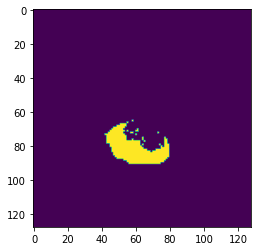

In [115]:
import matplotlib.pyplot as plt
plt.imshow(seg[0, :, :, 2])
plt.show()

In [ ]:
# Z losowaniem - 3.5s bez - 0.2s

In [242]:
model = architecture.build_model((dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE, dataloader.CHANNELS), NUM_CLASSES)

In [ ]:
model.layers[1].get_layer('depthwise_conv2d_26').trainable_weights

In [243]:
model.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_23 (InputLayer)       [(None, 128, 128, 4)]        0         []                            
                                                                                                  
 sequential_176 (Sequential  (None, 128, 128, 16)         33136     ['input_23[0][0]']            
 )                                                                                                
                                                                                                  
 inception_module_136 (Ince  (None, 64, 64, 16)           824       ['sequential_176[0][0]']      
 ptionModule)                                                                                     
                                                                                           

In [244]:
steps_per_epoch = len(train_brains) * (dataloader.BRAIN_FRAMES//BATCH_SIZE)
val_steps_per_epoch = len(val_brains) * (dataloader.BRAIN_FRAMES//BATCH_SIZE)
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=1e-4,
    maximal_learning_rate=1e-2,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2 * steps_per_epoch
)

In [245]:
model.compile(loss=metrics.weighted_f1_loss, optimizer=tf.keras.optimizers.AdamW(learning_rate=clr, weight_decay=0.007), metrics=['accuracy', 
                                                                                               tf.keras.metrics.OneHotMeanIoU(num_classes=NUM_CLASSES),
                                                                                               tf.keras.metrics.OneHotIoU(num_classes=NUM_CLASSES, target_class_ids=[0]),
                                                                                               tf.keras.metrics.OneHotIoU(num_classes=NUM_CLASSES, target_class_ids=[1]),
                                                                                               tf.keras.metrics.OneHotIoU(num_classes=NUM_CLASSES, target_class_ids=[2]),
                                                                                               tf.keras.metrics.OneHotIoU(num_classes=NUM_CLASSES, target_class_ids=[3]),
                                                                                               tf.keras.metrics.Precision(class_id=0),
                                                                                               tf.keras.metrics.Precision(class_id=1),
                                                                                               tf.keras.metrics.Precision(class_id=2),
                                                                                               tf.keras.metrics.Precision(class_id=3),
                                                                                               tf.keras.metrics.Recall(class_id=0),
                                                                                               tf.keras.metrics.Recall(class_id=1),
                                                                                               tf.keras.metrics.Recall(class_id=2),
                                                                                               tf.keras.metrics.Recall(class_id=3)])

In [170]:
checkpoint_filepath = os.path.join(ROOT_DIR, 'checkpoints', 'model-{epoch:02d}-{val_one_hot_mean_io_u:.3f}')

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_one_hot_mean_io_u',
    mode='max',
    save_best_only=True)

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, restore_best_weights=True)

csv_logger_callback = tf.keras.callbacks.CSVLogger('brainTumor.log')

In [68]:
history = model.fit(train_dataset, epochs=1, steps_per_epoch=20, validation_data=val_dataset, validation_steps=3)

20/20 [==============================] - 296s 14s/step - loss: 0.9797 - accuracy: 0.4901 - one_hot_mean_io_u_9: 0.1326 - one_hot_io_u_36: 0.4916 - one_hot_io_u_37: 0.0172 - one_hot_io_u_38: 0.0172 - one_hot_io_u_39: 0.0042 - weighted_f1: 0.0194 - precision_36: 0.9913 - precision_37: 0.0603 - precision_38: 0.0213 - precision_39: 0.0034 - recall_36: 0.4297 - recall_37: 0.0228 - recall_38: 0.0243 - recall_39: 0.2333 - val_loss: 0.9974 - val_accuracy: 0.8020 - val_one_hot_mean_io_u_9: 0.2015 - val_one_hot_io_u_36: 0.8031 - val_one_hot_io_u_37: 0.0000e+00 - val_one_hot_io_u_38: 0.0000e+00 - val_one_hot_io_u_39: 0.0029 - val_weighted_f1: 0.0025 - val_precision_36: 0.9889 - val_precision_37: 0.0000e+00 - val_precision_38: 0.0000e+00 - val_precision_39: 0.0030 - val_recall_36: 0.8102 - val_recall_37: 0.0000e+00 - val_recall_38: 0.0000e+00 - val_recall_39: 0.1876


In [35]:
history = model.fit(train_dataset, epochs=1, steps_per_epoch=20, validation_data=val_dataset, validation_steps=3)

20/20 [==============================] - 125s 5s/step - loss: 0.9805 - accuracy: 0.3011 - one_hot_mean_io_u_6: 0.0893 - one_hot_io_u_24: 0.3012 - one_hot_io_u_25: 0.0346 - one_hot_io_u_26: 0.0014 - one_hot_io_u_27: 0.0199 - weighted_f1: 0.0174 - precision_24: 0.9995 - precision_25: 0.0498 - precision_26: 0.0012 - precision_27: 0.0306 - recall_24: 0.1866 - recall_25: 0.1768 - recall_26: 0.1760 - recall_27: 0.2441 - val_loss: 0.9968 - val_accuracy: 0.7839 - val_one_hot_mean_io_u_6: 0.1970 - val_one_hot_io_u_24: 0.7863 - val_one_hot_io_u_25: 0.0000e+00 - val_one_hot_io_u_26: 0.0017 - val_one_hot_io_u_27: 0.0000e+00 - val_weighted_f1: 0.0031 - val_precision_24: 0.9820 - val_precision_25: 0.0000e+00 - val_precision_26: 0.0017 - val_precision_27: 0.0000e+00 - val_recall_24: 0.7966 - val_recall_25: 0.0000e+00 - val_recall_26: 0.1929 - val_recall_27: 0.0000e+00


In [ ]:
history = model.fit(train_dataset, epochs=1, steps_per_epoch=steps_per_epoch, validation_data=val_dataset, validation_steps=val_steps_per_epoch)

In [191]:
import nibabel as nib
import cv2

t1 = cv2.resize(nib.load(f'{dataloader.extend_path_from_last_part(train_brains[0])}_t1.nii').get_fdata()[:, :, 70], (128, 128))
t1ce = cv2.resize(nib.load(f'{dataloader.extend_path_from_last_part(train_brains[0])}_t1ce.nii').get_fdata()[:, :, 70], (128, 128))
t2 = cv2.resize(nib.load(f'{dataloader.extend_path_from_last_part(train_brains[0])}_t2.nii').get_fdata()[:, :, 70], (128, 128))
flair = cv2.resize(nib.load(f'{dataloader.extend_path_from_last_part(train_brains[0])}_flair.nii').get_fdata()[:, :, 70], (128, 128))
seg = cv2.resize(nib.load(f'{dataloader.extend_path_from_last_part(train_brains[0])}_seg.nii').get_fdata()[:, :, 70], (128, 128))

In [192]:
seg = tf.one_hot(seg.reshape(1, 128, 128), 4, dtype=np.uint8)

In [193]:
test = np.concatenate([np.expand_dims(t1, axis=-1), np.expand_dims(t1ce, axis=-1), np.expand_dims(t2, axis=-1), np.expand_dims(flair, axis=-1)], axis=-1)

In [194]:
pred = model.predict(test.reshape(1, 128, 128, 4))

1/1 [==============================] - 1s 1s/step


In [196]:
import matplotlib.pyplot as plt

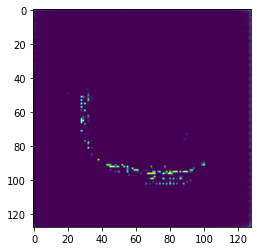

In [207]:
plt.imshow(pred[0][:, :, 0])

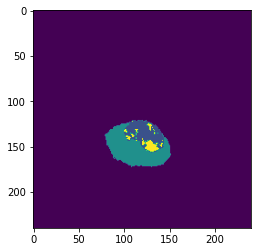

In [131]:
import matplotlib.pyplot as plt
plt.imshow(seg)

In [46]:
history.history

{'loss': [1.1112102270126343, 0.4273770749568939],
 'accuracy': [0.643875777721405, 0.9611085057258606],
 'one_hot_mean_io_u': [0.162858784198761, 0.2403409332036972],
 'one_hot_io_u': [0.6442953944206238, 0.961113691329956],
 'one_hot_io_u_1': [0.0, 0.0],
 'one_hot_io_u_2': [0.007139731198549271, 0.0002500144182704389],
 'one_hot_io_u_3': [0.0, 0.0],
 'weighted_f1': [0.4888043701648712, 0.8008794784545898],
 'precision': [1.0, 0.9833060503005981],
 'precision_1': [0.0, 0.0],
 'precision_2': [0.0, 0.0],
 'precision_3': [0.0, 0.0],
 'recall': [0.005293977912515402, 0.7690828442573547],
 'recall_1': [0.0, 0.0],
 'recall_2': [0.0, 0.0],
 'recall_3': [0.0, 0.0],
 'val_loss': [0.7661035656929016, 0.09657168388366699],
 'val_accuracy': [0.9624722599983215, 0.9846280217170715],
 'val_one_hot_mean_io_u': [0.24061806499958038, 0.24615700542926788],
 'val_one_hot_io_u': [0.9624722599983215, 0.9846280217170715],
 'val_one_hot_io_u_1': [0.0, 0.0],
 'val_one_hot_io_u_2': [0.0, 0.0],
 'val_one_hot_i

In [44]:
history = model.fit(train_dataset, epochs=1, steps_per_epoch=len(train_brains) * (dataloader.BRAIN_FRAMES//BATCH_SIZE), validation_data=val_dataset)

Epoch 1/2
768/768 [==============================] - 3951s 5s/step - loss: 0.1080 - accuracy: 0.9780 - val_loss: 0.1126 - val_accuracy: 0.9794
Epoch 2/2
768/768 [==============================] - 169s 220ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.1126 - val_accuracy: 0.9794


In [22]:
model.evaluate()

228/228 [==============================] - 195s 854ms/step - loss: 0.0924 - accuracy: 0.9782


[0.09240186959505081, 0.9781610369682312]